In [16]:
!pip install shap==0.47.1
!pip install anchor==0.4.0
!pip install alibi


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [22]:
# Necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import shap
from alibi.explainers import AnchorTabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.3/227.3 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.4/481.4 kB 50.6 MB/s eta 0:00:00
  Attempting uninstall: Pillow
   

In [24]:
#random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [26]:
# --- Step 1: Load and Prepare Dataset ---
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv"
data = pd.read_csv(url, header=None)
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
          'Insulin', 'BMI', 'DiabetesPedigree', 'Age', 'Outcome']
data.columns = columns

# Features and target
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

BNN Prediction for Patient: 0.411
Uncertainty (Std Dev): 0.077


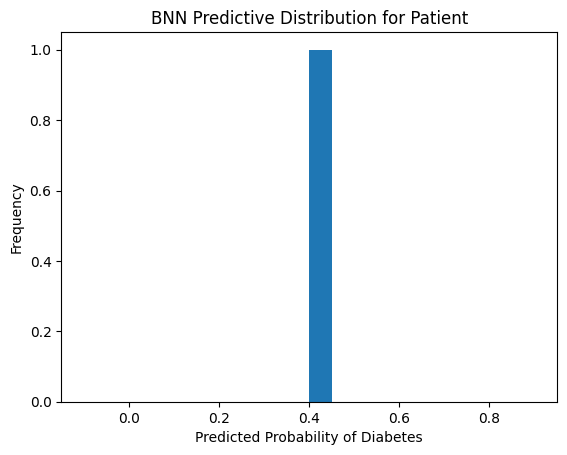

In [28]:
# --- Step 2: Bayesian Neural Network with Monte Carlo Dropout ---
def build_bnn_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and train the model
bnn_model = build_bnn_model(X_train.shape[1])
bnn_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# MC Dropout inference
def mc_dropout_predict(model, X, n_samples=100):
    predictions = np.array([model(X, training=True) for _ in range(n_samples)])
    mean_pred = predictions.mean(axis=0)
    uncertainty = predictions.std(axis=0)
    return mean_pred, uncertainty

# Test on a single patient
patient_idx = 0
X_patient = X_test[patient_idx:patient_idx+1]
mean_pred, uncertainty = mc_dropout_predict(bnn_model, X_patient)

print(f"BNN Prediction for Patient: {mean_pred[0][0]:.3f}")
print(f"Uncertainty (Std Dev): {uncertainty[0][0]:.3f}")

# Visualize uncertainty
plt.hist(mc_dropout_predict(bnn_model, X_patient, 100)[0].flatten(), bins=20)
plt.title("BNN Predictive Distribution for Patient")
plt.xlabel("Predicted Probability of Diabetes")
plt.ylabel("Frequency")
plt.show()

In [30]:
# --- Step 3: Autoencoder for Anomaly Detection ---
def build_autoencoder(input_dim):
    encoder = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu')
    ])
    decoder = models.Sequential([
        layers.Dense(32, activation='relu'),
        layers.Dense(input_dim, activation='linear')
    ])
    autoencoder = models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

# Build and train on normal data (Outcome=0)
normal_data = X_train[y_train == 0]
autoencoder, encoder = build_autoencoder(X_train.shape[1])
autoencoder.fit(normal_data, normal_data, epochs=20, batch_size=32, verbose=0)

# Reconstruction error for anomaly detection
reconstructions = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.square(X_test - reconstructions), axis=1)

# Flag anomalies (top 10% errors)
threshold = np.percentile(reconstruction_error, 90)
anomalies = reconstruction_error > threshold

print(f"Number of anomalies detected: {np.sum(anomalies)}")

5/5 [==============================] - 0s 2ms/step
Number of anomalies detected: 16


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]
/tmp/ipykernel_79/1489903661.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_anomaly, feature_names=columns[:-1], plot_type="bar")


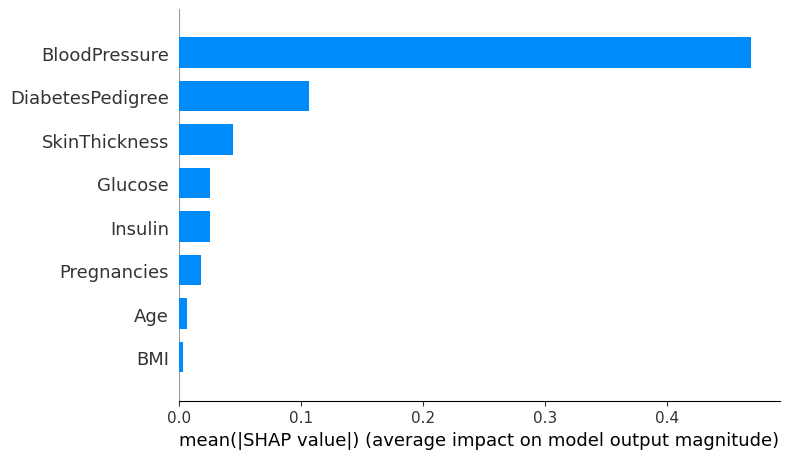

Text(0.5, 1.0, 'Feature Contributions to Anomaly (SHAP)')

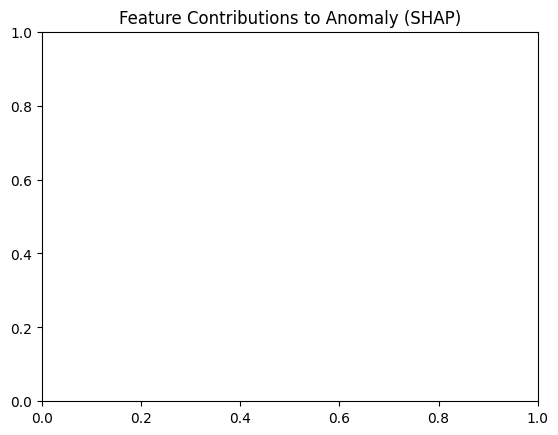

In [32]:
# --- Step 4: Feature Attribution with SHAP ---
anomaly_idx = np.where(anomalies)[0][0]
X_anomaly = X_test[anomaly_idx:anomaly_idx+1]

def ae_predict(X):
    return np.mean(np.square(X - autoencoder.predict(X, verbose=0)), axis=1)

background = X_train[:100]
explainer = shap.KernelExplainer(ae_predict, background)
shap_values = explainer.shap_values(X_anomaly)

# Plot SHAP values
shap.summary_plot(shap_values, X_anomaly, feature_names=columns[:-1], plot_type="bar")
plt.title("Feature Contributions to Anomaly (SHAP)")

In [39]:
# --- Step 5: Anchors XAI for BNN Prediction ---

# Define a prediction function for Anchors
def bnn_predict_for_anchors(X):
    mean_pred, _ = mc_dropout_predict(bnn_model, X, n_samples=100)
    return (mean_pred > 0.5).astype(int).flatten()

# Initialize Anchors explainer
explainer = AnchorTabular(
    predictor=bnn_predict_for_anchors,
    feature_names=columns[:-1]  # Removed target_names as it's not a valid parameter
)

# Fit the explainer
explainer.fit(X_train, categorical_names={})

# Generate explanation for the patient
anchor_exp = explainer.explain(X_patient[0])

# Display Anchors explanation
print("\n--- Anchors Explanation for BNN Prediction ---")
print(f"Anchor Rule: {anchor_exp.anchor}")
print(f"Precision: {anchor_exp.precision:.3f}")
print(f"Coverage: {anchor_exp.coverage:.3f}")


--- Anchors Explanation for BNN Prediction ---
Anchor Rule: ['Glucose <= -0.65']
Precision: 0.961
Coverage: 0.270



--- Results ---
BNN with MC Dropout: Predicted diabetes probability = 0.411, Uncertainty = 0.077
Autoencoder: Reconstruction error for anomaly = 0.679
Anomaly detected: True
Anchors Rule for Patient: ['Glucose <= -0.65'] (Precision: 0.961)


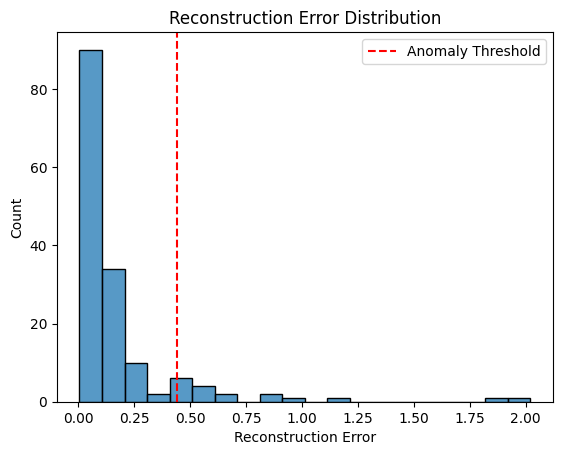

In [43]:
# --- Step 6: Results and Discussion ---
print("\n--- Results ---")
print(f"BNN with MC Dropout: Predicted diabetes probability = {mean_pred[0][0]:.3f}, Uncertainty = {uncertainty[0][0]:.3f}")
print(f"Autoencoder: Reconstruction error for anomaly = {reconstruction_error[anomaly_idx]:.3f}")
print(f"Anomaly detected: {anomalies[anomaly_idx]}")
print(f"Anchors Rule for Patient: {anchor_exp.anchor} (Precision: {anchor_exp.precision:.3f})")

# Plot reconstruction error distribution
plt.figure()
sns.histplot(reconstruction_error, bins=20)
plt.axvline(threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9767022b-cbb7-46c9-ab81-5944f3af6a18' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>